In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class FCN(nn.Module):
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

# Burgers equation 1D

In [115]:
boundary_nodes = np.zeros([100,2])
boundary_nodes[0:50,0]=1
boundary_nodes[0:50,1]=np.random.uniform(low=0.0, high=1, size=(50,))
boundary_nodes[50:,0]=-1
boundary_nodes[50:,1]=np.random.uniform(low=0.0, high=1, size=(50,))

In [116]:
initial_data_nodes = np.zeros([100,2])
initial_data_nodes[:,0]=np.random.uniform(low=-1.0, high=1, size=(100,))
initial_data_nodes[:,1]=0
initial_data_values = -np.sin(np.pi*initial_data_nodes[:,0])

In [117]:
collocation_data_nodes = np.zeros([5000,2])
collocation_data_nodes[:,0]=np.random.uniform(low=-1.0, high=1, size=(5000,))
collocation_data_nodes[:,1]=np.random.uniform(low=0.0, high=1, size=(5000,))


In [118]:
x_axis = np.linspace(-1, 1, 100)
t_axis = np.linspace(0, 1, 200)
xv, yv = np.meshgrid(x_axis, t_axis)

grid = np.zeros([20000,2])
grid[:,0] = xv.flatten()
grid[:,1] = yv.flatten()

grid_t = torch.tensor(grid,dtype=torch.float)

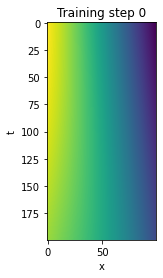

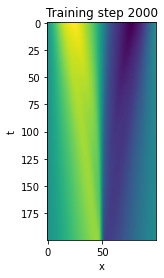

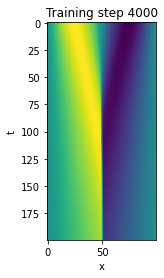

In [142]:
torch.manual_seed(123)

# define a neural network to train
pinn = FCN(2,1,32,3)

# define nodes
boundary_nodes_t = torch.tensor(boundary_nodes,dtype=torch.float) 
initial_data_nodes_t = torch.tensor(initial_data_nodes,dtype=torch.float) 
collocation_data_nodes_t = torch.tensor(collocation_data_nodes,dtype=torch.float) 
initial_data_values_t = torch.tensor(initial_data_values,dtype=torch.float)

boundary_nodes_t.requires_grad = True
collocation_data_nodes_t.requires_grad = True
initial_data_nodes_t.requires_grad = True
# train the PINN
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-3)
for i in range(5000):
    optimiser.zero_grad()
    
    lambda1, lambda2, lambda3 = 1,1e-4,1e-1
   
    # compute initial data loss
    u = pinn(initial_data_nodes_t)
    loss1 = torch.mean((torch.squeeze(u) - initial_data_values_t)**2)
    
    # compute boundary loss
    u = pinn(boundary_nodes_t)
    loss2 = torch.mean((u - torch.zeros(u.shape))**2)
    
    # compute physics loss
    u = pinn(collocation_data_nodes_t)
    du = torch.autograd.grad(u, collocation_data_nodes_t,\
                             torch.ones([collocation_data_nodes_t.shape[0], 1]),\
                             retain_graph=True, create_graph=True)[0]
    du2 = torch.autograd.grad(du, collocation_data_nodes_t,\
                              torch.ones(collocation_data_nodes_t.shape),\
                              create_graph=True)[0]
    u_x  = du[:,[0]]
    u_t  = du[:,[1]]
    u_xx = du2[:,[0]]
    loss3 = torch.mean((u_t + u*u_x - .01 / np.pi *u_xx)**2)
    
    # backpropagate joint loss, take optimiser step
    loss = lambda1*loss1 + lambda2*loss2 + lambda1*loss3
    loss.backward()
    optimiser.step()
    
    # plot the result as training progresses
    if i % 2000 == 0: 
        u = pinn(grid_t)
        plt.imshow(u.detach().numpy().reshape(200,100))
        plt.ylabel('t')
        plt.xlabel('x')
        plt.title(f"Training step {i}")
        plt.show()


In [143]:
u = pinn(grid_t)
sol = u.detach().numpy()

Text(0.5, 1.0, 't=0.5')

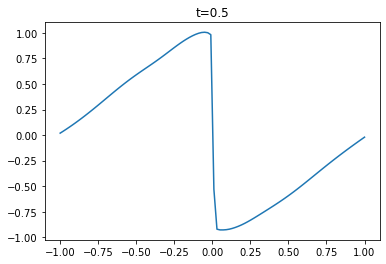

In [146]:
plt.plot(grid[10000:10100,0],sol[10000:10100])
plt.title("t=0.5")

# Solving ODE

Adapted from https://github.com/benmoseley/DLSC-2023/

In [ ]:
def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

In [147]:
boundary_nodes = np.zeros(1)
collocation_nodes = np.linspace(0,1,30)
test_nodes = np.linspace(0,1,300)

boundary_nodes_t = torch.tensor(boundary_nodes,dtype=torch.float).view(-1,1)
collocation_nodes_t = torch.tensor(collocation_nodes,dtype=torch.float).view(-1,1)
test_nodes_t = torch.tensor(test_nodes,dtype=torch.float).view(-1,1)

boundary_nodes_t.requires_grad = True
collocation_nodes_t.requires_grad = True
test_nodes_t.requires_grad = True

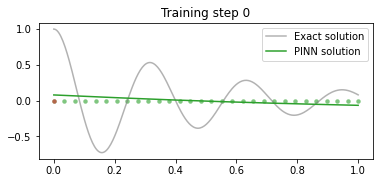

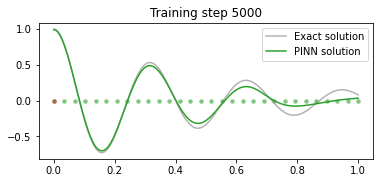

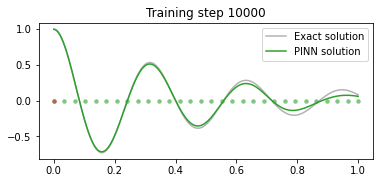

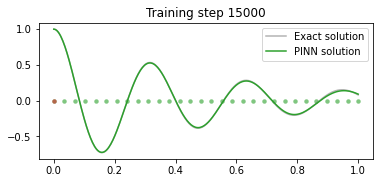

In [155]:
torch.manual_seed(123)

pinn = FCN(1,1,32,3)

# train the PINN
d, w0 = 2, 20
mu, k = 2*d, w0**2
u_exact = exact_solution(d, w0, test_nodes_t)
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-3)
for i in range(15001):
    optimiser.zero_grad()
    
    lambda1, lambda2 = 1e-1, 1e-4
    
    # compute boundary loss
    u = pinn(boundary_nodes_t)
    loss1 = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, boundary_nodes_t,\
                               torch.ones_like(u),retain_graph=True, create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2
    
    # compute physics loss
    u = pinn(collocation_nodes_t)
    dudt = torch.autograd.grad(u, collocation_nodes_t,\
                               torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, collocation_nodes_t,\
                                 torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)
    
    # backpropagate joint loss, take optimiser step
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimiser.step()
    
    # plot the result as training progresses
    if i % 5000 == 0: 
        u = pinn(test_nodes_t).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(collocation_nodes_t.detach()[:,0], 
                    torch.zeros_like(collocation_nodes_t)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(boundary_nodes_t.detach()[:,0], 
                    torch.zeros_like(boundary_nodes_t)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(test_nodes_t[:,0].detach().numpy(), u_exact[:,0].detach().numpy(), label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(test_nodes_t[:,0].detach().numpy(), u[:,0].detach().numpy(), label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()